# Genetic Algorithms in Python

#### Dr. Mathew Smith, ADACS, Swinburne University of Technology

The application of Genetic Algorithsm (GA's) has become increasingly popular in engineering, mathematics and science research for studies and applications involving optimization. In this notebook, we examine the implementation of a Differential Evolution (DE) algorithm - a type of Genetic Algorithm - which emulates biological evolution for solution of an optimization problem. 

## Motivation

Consider the Goldstein-Price function f(X,Y), which has a global minima of f(X,Y) = 3 at X = 0 and Y = -1:

\begin{align}
f(X,Y) = (1 + (X+Y+1)^2(19-14X+3X^2-14Y+6XY+3Y^2)) \\
                (30 + (2X-3Y)^2(18-32X+12X^2+48Y-36XY+27Y^2))
                \end{align}

Suppose we wish to calculate the values of X and Y which provide the minimum (or maximum) value of f(X,Y). One may use a gradient-based approach - such as a Newton-Raphson based method - which employs partial derivitives of f(X,Y) with respect to X and Y and uses them to iterate towards the best values of X and Y. This approach may be complicated by the presence of local minima, which tend to trap solutions of this kind. So, in this case, we plan on using a Genetic Algorithm, which is a heuristic approach.

## Genetic Algorithm Preamble

In the equation above we have two solution parameters (specifically X and Y) which we shall refer to as genomes, collectively representing a solutions's DNA. For any given DNA pair, we have a value of f(X,Y) which we shall refer to as the "fitness" - which tells us "how good" the DNA is. Let's start by writing some Python code which computes the fitness based on the DNA:

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def ComputeFitness(X):
        # Compute the fitness based on genetic data X
        # X is an array of dimension (NO_VAR)
        # The goal of the GA is the find the value of X which results
        # in a maximum or mimimum value of this fitness function.

        # Compute the Goldstein-Price function (two variables)
        fitness = (1.0 + (X[0]+X[1]+1.0)*(X[0]+X[1]+1.0)*(19.0-14.0*X[0]+3.0*X[0]*X[0]-14.0*X[1]+6.0*X[0]*X[1]+3.0*X[1]*X[1]))* \
                (30.0 + (2.0*X[0]-3.0*X[1])*(2.0*X[0]-3.0*X[1])*(18.0-32.0*X[0]+12.0*X[0]*X[0]+48.0*X[1]-36.0*X[0]*X[1]+27.0*X[1]*X[1]));

        return fitness

The ComputeFitness() function takes only one argument - an array X which holds our DNA information, a.k.a our optimization solution parameters. Since the Goldstein-Price function has only two parameters (X and Y), we expect X to have a length of 2. Next, we need a way of identifying the fittest individual inside a population - for this, we write another function.

In [2]:
def ComputeBestKid(FITNESS):
        # Computes the fittest child                              
        # FITNESS is an array of dimension (NO_KIDS)
        NO_KIDS = len(FITNESS)
        BestFitness = 10000.0
        BestIndex = -1
        for i in range(NO_KIDS):
                if (FITNESS[i] < BestFitness):
                        BestFitness = FITNESS[i]
                        BestIndex = i

        return BestIndex

In this case, as we wish to determine the minimum of the Goldstein-Price function, we are searching for a member of the population with the lowest value of the fitness. We are only interested in returning the best (fittest) member of the population - or specifically, the index to them, which we will require for the next function - the ComputeNextGeneration() function.

## Genetic Algorithm Core

Below you'll see a section of code which contains the core components of the Differential Evolution (DE) computation. When moving from generation to generation, the DNA of the members evolves through reproduction - that is, parents are selected and the DNA for their offspring selected based on the value of the parents. In this approach, we actually have 3 parents:

* Parent A, which is always the member of the generation which is the "fittest" - in this case, the parent which has the lowest value of the Goldstein-Price function.
* Parents B and C, which are randomly selected parents from the population.

When computing the value of a child's DNA, there are two steps - combination and mutation. 

### Reproduction - Combination

In the case of this Differential Evolution algorithm, combination is the linear process by which two parents contribute towards their child's genome. We might imagine that the genome of a child is based on a weighted contribution from their parents:

\begin{align}
X_{child} = W_f X_A + (1-W_f) X_B
\end{align}

Where $W_f$ is a value between 0 and 1. In the case of the algorithm below, the value of $W_f$ is computed as:

\begin{align}
W_f = FR*max(R_f, 1 - R_f)
\end{align}

where $R_f$ is a random number generated from a uniform distribution from 0 to 1. In this way, we can see that, while the contribution to the childs genome is random, we always tend to lean towards Parent A - which, as you might recall, was the "fittest" parent. Finally, we have a parameter - FR - which is nominally unity (i.e. 1) but can be increased to accelerate convergence on an optimal solution.

### Reproduction - Mutation

In biology, mutation is the result of an error occuring during the DNA replication process - resulting in an increased variance in population parameters in a seemingly random manner. We have adopted this process in our reproduction phase of our genetic algorithm - the value of a childs genome is subject to random alteration based on the variance of that genome in the population. In the algorithm used in the python script below, we select a third parent (Parent C) to help predict the amount of variance present (for any given genome) which is then used to compute the magnitude of the mutation applied. 

Taking mutation into account, the value of a new child's genome is:

\begin{align}
X_{child} = W_f X_A + (1-W_f) X_B + \sigma R_n (X_C - X_B)
\end{align}

where the first part is the combination process described previously, and $R_n$ is a normally distributed random number with a mean of 0 and a variance of 1 and $\sigma$ is a solution parameter (nominally 1) which we can control to increase / decrease the amount of mutation present. 




In [3]:
def MaxMod(X):
        if (X > 0.5):
                return X
        else:
                return (1.0-X)
            

def ComputeNextGeneration(DNA, FITNESS, BESTINDEX, FR, SIGMA):

        NO_KIDS,NO_VAR = DNA.shape
        trial_dna = np.empty(NO_VAR)

        # Assume the next generation will be identical
        new_dna = DNA
        new_fitness = FITNESS

        # Compute a replacement for each member of this generation
        for i in range(NO_KIDS):
                # Pick parents
                Parent_A = BESTINDEX
                Parent_B = Parent_A
                Parent_C = Parent_A
                while ((Parent_A == Parent_B) or (Parent_A == Parent_C) or (Parent_B == Parent_C)):
                        # Select Parent B and C randomly from the population
                        Parent_B = np.random.randint(NO_KIDS)
                        Parent_C = np.random.randint(NO_KIDS)

                # Compute the dna of the trial child
                for j in range(NO_VAR):
                        Rf = FR*MaxMod(np.random.rand())
                        Rnf = SIGMA*np.random.randn()
                        trial_dna[j] = Rf*DNA[Parent_A,j]+(1.0-Rf)*DNA[Parent_B,j] + Rnf*(DNA[Parent_B,j]-DNA[Parent_C,j])

                # Compute the fitness of the trial child
                trial_fitness = ComputeFitness(trial_dna)

                
                if (np.abs(trial_fitness) < np.abs(FITNESS[i])):
                        # This trial child has better dna. Make the change.
                        new_fitness[i] = trial_fitness
                        new_dna[i,:] = trial_dna

        # Return the next generations data
        return new_dna, new_fitness


### Running the Simulation

Now we have all the functions we need taken care of, we can start by choosing the number of kids in each generation (NO_KIDS), the number of solution parameters we have (NO_VAR = 2 for the Goldstein-Price function), the number of generations (NO_GEN) and the values of $FR$ and $\sigma$ (SIGMA):

In [4]:
# Commence the main program sequence
# Assign solution parameters
NO_KIDS = 30
NO_VAR = 2
NO_GEN = 10
FR = 1.0
SIGMA = 1.0

Next, we need to set the initial values of the dna for the NO_KIDS kids in the population. Ideally, we would like the range of these initial values to be large enough to capture the global minima / maxima, but as we are about to see, this is not required: let's randomly guess the solutions for our minimization problem as being uniformly distributed across the range 0-1.

In [5]:
# Initialise the problem
kid_dna = np.random.rand(NO_KIDS, NO_VAR)
kid_fitness = np.zeros(NO_KIDS)
history_fitness = np.empty(NO_GEN)
history_dna = np.zeros((NO_GEN,NO_VAR))

Note that, above, we assign an array of zeros for the kids fitness. Let's compute the fitness for each child, and then find the best child - in this case, the one with the lowest value of the Goldstein-Price function - by calling some of the functions decribed previously:

In [6]:
# Find the child with the best dna
for i in range(NO_KIDS):
        kid_fitness[i] = ComputeFitness(kid_dna[i,:])
# Find the Index of the best kid based on fitness
BestKid = ComputeBestKid(kid_fitness)
print("The best kid in the population has fitness %g at (%g, %g)" % (kid_fitness[BestKid], kid_dna[BestKid,0], kid_dna[BestKid,1]))

The best kid in the population has fitness 674.849 at (0.0635186, 0.0436979)


We are finally ready to start our evolution simulation, where we have subsequent generations of children working together to produce new children whose genetic properties are computed using the algorithm we described above. For each generation, we need to:

* Compute the new generation's genetic properties (ComputeNextGeneration()), and
* Find the "alpha" in that generation (i.e. the best one) (ComputeBestKid())

We are also going to save some historical data so we can better understand the evolution towards our optimal result.

In [12]:
# Iterate over generations to evolve the population
for gen in range(NO_GEN):
        kid_dna, kid_fitness = ComputeNextGeneration(kid_dna,kid_fitness,BestKid, FR, SIGMA)
        BestKid = ComputeBestKid(kid_fitness)
        history_fitness[gen] = kid_fitness[BestKid]
        history_dna[gen,:] = kid_dna[BestKid,:]
        # Write a report
        print("Iteration %d - best fitness = %g at (%g, %g)" % (gen, kid_fitness[BestKid], kid_dna[BestKid,0], kid_dna[BestKid,1]))

Iteration 0 - best fitness = 3 at (9.25907e-06, -1.00002)
Iteration 1 - best fitness = 3 at (2.15225e-05, -0.999999)
Iteration 2 - best fitness = 3 at (3.42681e-06, -0.999993)
Iteration 3 - best fitness = 3 at (3.42681e-06, -0.999993)
Iteration 4 - best fitness = 3 at (-1.42156e-06, -1)
Iteration 5 - best fitness = 3 at (-2.29213e-07, -1)
Iteration 6 - best fitness = 3 at (-2.29213e-07, -1)
Iteration 7 - best fitness = 3 at (-3.54483e-07, -1)
Iteration 8 - best fitness = 3 at (-2.61496e-07, -1)
Iteration 9 - best fitness = 3 at (2.30424e-07, -1)


### Result

If everything has gone to plan, we can see that our population has produced a child containing our optimal solution, or something close to it. Keep in mind the analytical minima for the Goldstein-Price function is 3, located at (0,-1) - if we are lucky, we shoudl see that we have converged on this result. The iteration towards this result is not guaranteed to be smooth - advances through evolution rarely are. However, you might experiment with the values of $FR$ and $\sigma$ to see how they influence the rate at which we reach our solution.

Finally, let's have a look at the convergence on a graph:

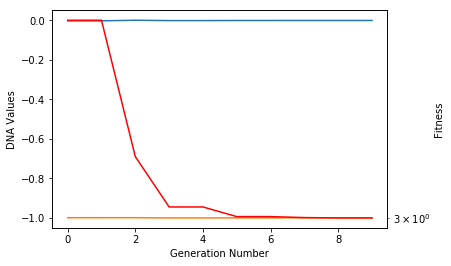

In [11]:
fig,ax = plt.subplots()
ax.plot(history_dna)
ax.set(xlabel='Generation Number',ylabel='DNA Values')
ax2 = ax.twinx()
ax2.semilogy(history_fitness,'r')
ax2.set(ylabel='Fitness')
plt.show()

And let's look at the value of the average fitness computed across for the entire population.

In [9]:
print("====== FINAL REPORT ========")
print("Average fitness of final generation = %g" % np.mean(kid_fitness))
print("Best Kid's Fitness: %g" % kid_fitness[BestKid])
print("Best Kid's DNA Parameter values:")
for i in range(NO_VAR):
        print("-- DNA Parameter %d = %g" % (i,kid_dna[BestKid,i]))


====== FINAL REPORT ========
Average fitness of final generation = 3.30492
Best Kid's Fitness: 3.00742
Best Kid's DNA Parameter values:
-- DNA Parameter 0 = -0.00298044
-- DNA Parameter 1 = -1.00428


## Concluding Remarks

Genetic Algorithms (GA's) have the ability to find global maxima or minima in functions which contain many local minima / maxima, and for this reason have found quite extensive use in complication optimization problems. Feel free to experiment with the function you are optimizing - you can find a list of functions used to test optimization routines by googling "optimization test cases".  